# **Tutorial on the C7eq to C7ax conformational transition in gas phase alanine dipeptide: GROMACS + PLUMED**
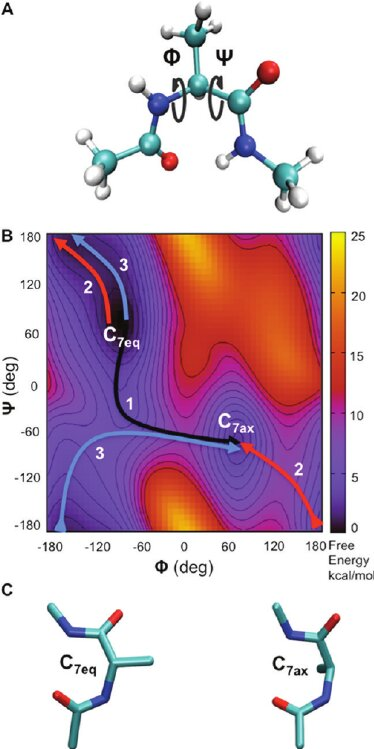

Figure Courtesy: Jagdish Suresh Patel, Davide Branduardi, Matteo Masetti, Walter Rocchia, and Andrea Cavalli
Journal of Chemical Theory and Computation 2011 7 (10), 3368-3378
DOI: 10.1021/ct200324j

Install Conda

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda --version

Install Plumed and Gromacs from conda for Masterclass tutorials

In [ ]:
!conda install numpy pandas
!conda install -c conda-forge plumed py-plumed
!conda install --strict-channel-priority -c plumed/label/masterclass -c conda-forge gromacs

**From GitHub, download the tutorial files**

In [ ]:
!rm -rf plumed_pytorch_tutorial
!git clone https://github.com/dhimanray/plumed_pytorch_tutorial.git

**First write the MD simulation input file and the PLUMED input file**

In [ ]:
path = 'plumed_pytorch_tutorial/ala2/'

##MD simulation input file:
md_input = """
;       Input file
define              =
; integrator
integrator          =  md        ;#Perform Molecular Dynamics
nsteps              =  200000      ;#Number of simulation steps
dt                  =  0.002     ;#Integration timestep in ps
cutoff-scheme       =  verlet    ;#velocity verlet algorithm
;
; removing CM translation and rotation
comm_mode           =  Linear
nstcomm             =  1000
;
; output control
nstlog                   = 5000
nstenergy                = 5000
nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
nstxout-compressed       = 500   ;#save trajectory every 500 steps
;
; neighbour searching
;nstlist             = 0
;ns-type             = simple
pbc                 = xyz
;rlist               = 1.0
periodic_molecules  = no
;
; electrostatic
rcoulomb            = 1.0
coulombtype         = Cut-off
;
; vdw
vdw-type            = Cut-off
rvdw                = 1.0
;
; constraints
constraints              = h-bonds
constraint-algorithm     = lincs
lincs_iter               = 4
;
; temperature (use thermostat to contol temperature)
Tcoupl              = v-rescale
tc_grps             = system
tau_t               = 0.1
ref_t               = 300.000
;
; pression
Pcoupl              =  no
;
; initial velocities (generate velocities at the beginning)
gen_vel             = yes
gen_temp            = 300.000
gen_seed            = -1

"""
with open(path+'md.mdp', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
theta: TORSION ATOMS=6,5,7,9

cosphi: MATHEVAL ARG=phi FUNC=cos(x) PERIODIC=NO
cospsi: MATHEVAL ARG=psi FUNC=cos(x) PERIODIC=NO
costheta: MATHEVAL ARG=theta FUNC=cos(x) PERIODIC=NO


meta: METAD ARG=phi PACE=100 HEIGHT=1.5 SIGMA=0.1 BIASFACTOR=10

PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=*

ENDPLUMED
"""

with open(path+'plumed.dat', 'w') as file:
  file.write(plumed_input)



**Run Molecular Dynamics Simulation with GROMACS**

In [ ]:
## COMMAND FOR RUNNING MOLECULAR DYNAMICS SIMULATION USING GROMACS
%%bash
cd plumed_pytorch_tutorial/ala2
gmx grompp -f md.mdp -c config.gro -p topol.top -o input.tpr
gmx mdrun -s input.tpr -deffnm alanine -plumed plumed.dat

**Perform plotting and analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate

N = 50 #number of points for plotting/interpolation

m = 15   #number of contours

x, y, z = np.genfromtxt(r'/content/plumed_pytorch_tutorial/ala2/2d_fes_ref', unpack=True)

for i in range(len(z)):
    if z[i] >= 50.0:
        z[i] = 50
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/COLVAR')

plt.scatter(l[:,1],l[:,2],c=l[:,0])
plt.xlabel('$\phi$ (rad)',fontsize=16)
plt.ylabel('$\psi$ (rad)',fontsize=16)
#plt.legend(fontsize=12)

In [ ]:
l = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/COLVAR')

plt.scatter(l[:,0],l[:,1],c=l[:,2])
plt.xlabel('Simulation Time (ps)',fontsize=16)
plt.ylabel('$\phi$ (rad)',fontsize=16)

In [ ]:
#Compute the Free Energy Landscape
!cd plumed_pytorch_tutorial/ala2 && plumed sum_hills --hills HILLS --kt 2.48 --mintozero

#Plot the free energy landscape
fes = np.loadtxt('plumed_pytorch_tutorial/ala2/fes.dat')
ref_fes = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/1d_fes_phi_ref')
plt.plot(fes[:,0],fes[:,1],label='this work')
plt.plot(ref_fes[:,0],ref_fes[:,1],label='reference')

plt.xlabel('$\phi$ (rad)',fontsize=16)
plt.ylabel('Free Energy (kJ/mol)',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
#CALCULATE FREE ENERGY FROM REWEIGHTING

!cd /content/plumed_pytorch_tutorial/ala2 && python FES_from_Reweighting.py --colvar COLVAR --cv phi --sigma 0.05 --temp 300 -o 1d_fes_phi
!cd /content/plumed_pytorch_tutorial/ala2 && python FES_from_Reweighting.py --colvar COLVAR --cv psi --sigma 0.05 --temp 300 -o 1d_fes_psi

fesphi = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/1d_fes_phi')
fesphi_ref = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/1d_fes_phi_ref')

plt.figure()
plt.plot(fesphi[:,0],fesphi[:,1],label='this work')
plt.plot(fesphi_ref[:,0],fesphi_ref[:,1],label='reference')
plt.xlabel('$\phi$ (rad)',fontsize=16)
plt.ylabel('Free Energy (kJ/mol)',fontsize=16)
plt.legend(fontsize=12)

fespsi = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/1d_fes_psi')
fespsi_ref = np.loadtxt('/content/plumed_pytorch_tutorial/ala2/1d_fes_psi_ref')

plt.figure()
plt.plot(fespsi[:,0],fespsi[:,1],label='this work')
plt.plot(fespsi_ref[:,0],fespsi_ref[:,1],label='reference')
plt.xlabel('$\psi$ (rad)',fontsize=16)
plt.ylabel('Free Energy (kJ/mol)',fontsize=16)
plt.legend(fontsize=12)